In [1]:
import os
import time
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.pde as pde
import solver.siren as siren
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizations as visualizations

import warnings
warnings.filterwarnings("ignore")

### Formulation of problem

In [13]:
def initial_condition_function(x):
    return 5 * (torch.sin(torch.pi * torch.tensor(x[:, 0])) * torch.sin(torch.pi * torch.tensor(x[:, 1]))).reshape(-1, 1)

# def boundary_condition_function(x, t):
#     return torch.sin(torch.pi * torch.tensor(x[:, 0])).reshape(-1, 1)

def boundary_condition_function(x, t):
    x_tensor = torch.tensor(x, device="cuda:0")
    t_tensor = torch.tensor(t, device="cuda:0")

    # Initialize the output tensor
    u = torch.zeros(x_tensor.shape[0], 1, device="cuda:0")
    
    # Boundary conditions for x = 0 and x = 1
    u[x_tensor[:, 0] == 0] = x_tensor[x_tensor[:, 0] == 0, 1].reshape(-1, 1)  # u(0, y, t) = y
    u[x_tensor[:, 0] == 1] = (1 - x_tensor[x_tensor[:, 0] == 1, 1]).reshape(-1, 1)  # u(1, y, t) = 1 - y
    
    # Boundary conditions for y = 0 and y = 1
    u[x_tensor[:, 1] == 0] = x_tensor[x_tensor[:, 1] == 0, 0].reshape(-1, 1)  # u(x, 0, t) = x
    u[x_tensor[:, 1] == 1] = (1 - x_tensor[x_tensor[:, 1] == 1, 0]).reshape(-1, 1)  # u(x, 1, t) = 1 - x

    return u

def fdm_solver(problem, Nx, Ny, last_only=False):
    Lx, Ly = problem.geom.size()
    T = problem.period.t1
    a = problem.alpha

    dx = Lx / (Nx - 1)
    dy = Ly / (Ny - 1)
    dt = min(dx, dy) ** 2 / (4 * a)

    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    Nt = int(T / dt)
    t = torch.linspace(0, T, Nt)

    u = torch.zeros((Nt, Nx, Ny))
    initial_xy = torch.stack([x.repeat(Ny), y.repeat_interleave(Nx)], dim=1)
    u[0, :, :] = problem.initial_conditions.initial_func(initial_xy).reshape(Nx, Ny)

    for n in tqdm(range(Nt - 1), desc='Computing'):
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                u[n + 1, i, j] = u[n, i, j] + a * dt / dx**2 * (u[n, i + 1, j] - 2 * u[n, i, j] + u[n, i - 1, j]) \
                                          + a * dt / dy**2 * (u[n, i, j + 1] - 2 * u[n, i, j] + u[n, i, j - 1])
        boundary_xy = torch.stack([x.repeat(Ny), y.repeat_interleave(Nx)], dim=1)
        
        t_current = torch.full((Ny,), dt * (n + 1))
        u[n + 1, 0, :] = problem.boundary_conditions.boundary_func(boundary_xy[0:Ny], t_current).reshape(Ny)

        t_current = torch.full((Ny,), dt * (n + 1))
        u[n + 1, -1, :] = problem.boundary_conditions.boundary_func(boundary_xy[-Ny:], t_current).reshape(Ny)

        t_current = torch.full((Nx,), dt * (n + 1))
        u[n + 1, :, 0] = problem.boundary_conditions.boundary_func(boundary_xy[::Ny], t_current).reshape(Nx)

        t_current = torch.full((Nx,), dt * (n + 1))
        u[n + 1, :, -1] = problem.boundary_conditions.boundary_func(boundary_xy[Ny-1::Ny], t_current).reshape(Nx)
        
    if last_only:
        return u[-1, :, :]
    else:
        x, y, t = torch.meshgrid(x, y, t, indexing='xy')
        u = u.permute(2, 1, 0)
        xy = torch.stack([x.flatten(), y.flatten()], dim=-1)
        t = t.reshape(-1, 1)
        u = u.reshape(-1, 1)
        return xy, t, u

torch.Size([10000, 2]) torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([10000, 2]) torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([5376, 2]) torch.Size([5376, 1])
torch.Size([961, 2]) torch.Size([961, 1])


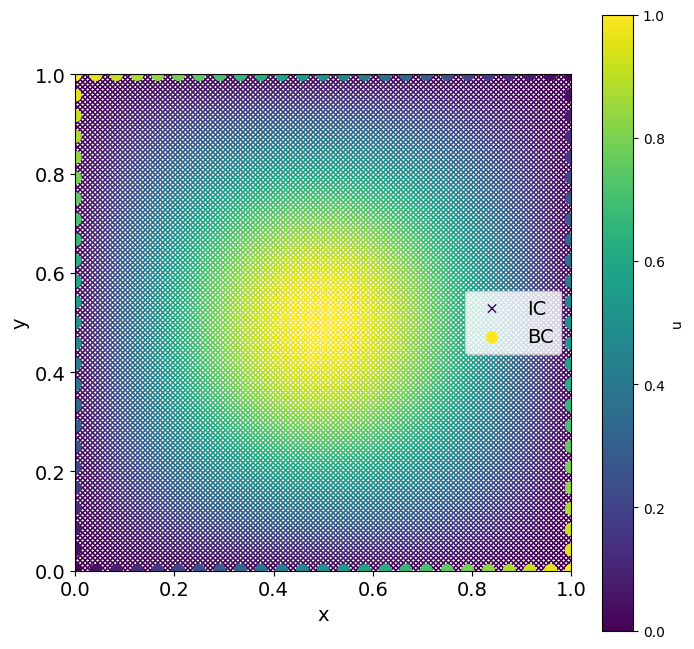

In [14]:
geom = geometry.Rectangle(0.0, 1.0, 0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)

initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                          initial_func=initial_condition_function, 
                                          num_points=10000, random=False, device="cuda:0")
x, t, u = initial_conditions.get_initial_conditions()
print(x.shape, t.shape, u.shape)

boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                            boundary_func=boundary_condition_function, 
                                            num_points=10000, random=False, device="cuda:0")
x, t, u = boundary_conditions.get_boundary_conditions()
print(x.shape, t.shape, u.shape)

pde_heat = pde.PDE('heat2D', alpha=0.1)

equation = conditions.Equation()
equation.set_equation(pde = pde_heat, geom=geom, time=period, num_points=10000, random=False, device="cuda:0")
x, t = equation.get_equation_points()
print(x.shape, t.shape)

test = conditions.Test()
test.set_test(geom=geom, time=period, num_points=1000, random=False, device="cuda:0")
x, t = test.get_test()
print(x.shape, t.shape)

problem = conditions.Problem(initial_conditions, 
                             boundary_conditions, 
                             equation, test,
                             geom, period, alpha=0.1)

visualizations.conditions_plot(problem, t=0.0)

Computing: 100%|██████████| 15/15 [00:00<00:00, 65.47it/s]


torch.Size([1600, 2]) torch.Size([1600, 1]) torch.Size([1600, 1])


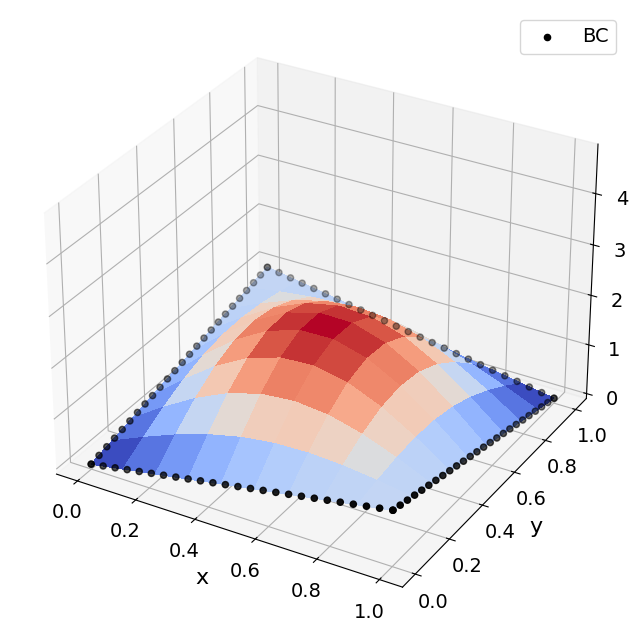

In [15]:
x_initial, t_initial, u_initial = problem.initial_conditions.get_initial_conditions()
x_boundary, t_boundary, u_boundary = problem.boundary_conditions.get_boundary_conditions()

x_equation, t_equation, u_equation = fdm_solver(problem=problem, Nx=10, Ny=10)
solution = conditions.Solution()
solution.set_solution(x_equation, t_equation, u_equation)
print(x_equation.shape, t_equation.shape, u_equation.shape)

visualizations.solution_surface_plot(problem, solution)

### PINN for 2d problem

In [7]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = utils.NetParams()
net_params.set_params(input=3,
                      output=1,
                      hidden_layers=[int(64) for _ in range(1)],
                      epochs=15000,
                      batch_size=100,
                      lr=0.0001,
                      activation='sin',
                      training_mode='train',
                      regularization='Elastic',
                      lambda_reg=0.01,
                      optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler=None, # Not applicable with Hybrid optimizer
                      # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                      early_stopping=False, # Some problem
                      use_rar=False,
                      use_weights_adjuster=False,
                      display_interval=100,
                      model_save_path='models',
                      output_path='out',
                      save_loss=True,
                      initial_weights_path=None, # 'models/model_weights.pth'
                      siren_params=siren_params)

# TODO: Early stopping not work correctly
# Or load from json file
# net_params.from_json_file("params.json")

In [8]:
model = pinn.PINN(problem, net_params, device='cuda:0')
model.training_mode
model.train()
model.save_weights()

2
Activation Function: Sin
Hidden Dimensions: 1
Number of neurons: 64
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=3, out_features=64, bias=True)
) -> Linear
Layer 1: Linear(in_features=64, out_features=1, bias=True)
----------
Next number: 309
Oprtimizer: Adam
Iteration 100: Loss 0.5108403563499451, Weighted Loss 1693.2210693359375, Time 1.0883328914642334
Iteration 200: Loss 0.4051862955093384, Weighted Loss 1022.4314575195312, Time 1.9479107856750488
Iteration 300: Loss 0.2979600131511688, Weighted Loss 499.5225524902344, Time 2.761732339859009
Iteration 400: Loss 0.2207140028476715, Weighted Loss 266.2244567871094, Time 3.703751802444458
Iteration 500: Loss 0.15830302238464355, Weighted Loss 176.07220458984375, Time 4.553887844085693
Iteration 600: Loss 0.10927460342645645, Weighted Loss 120.53461456298828, Time 5.393516540527344
Iteration 700: Loss 0.07317596673965454, Weighted Loss 81.24547576904297, Time 6.2308361530303955
Iteration 800: Loss 0.04651243984699249

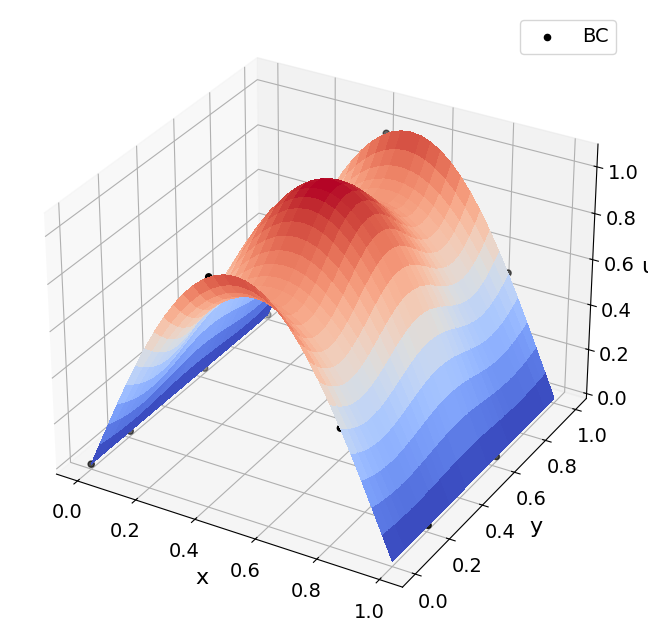

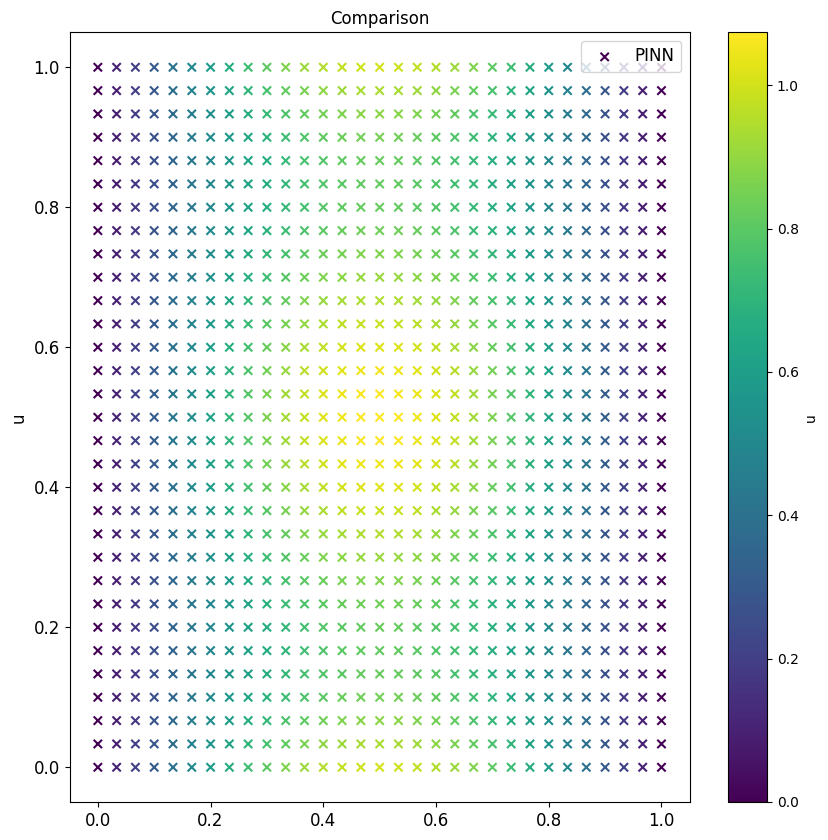

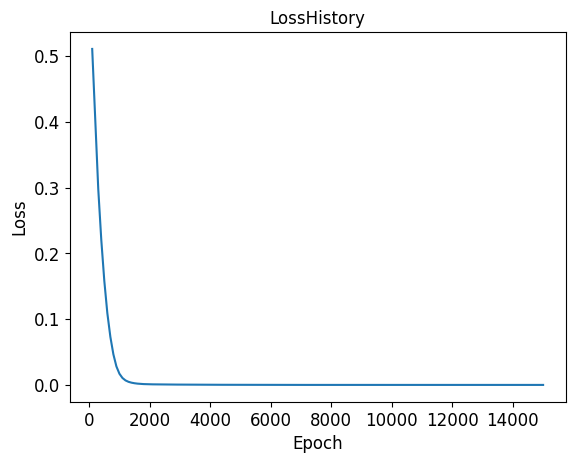

In [9]:
x, t = problem.test.get_test()
u_pinn = model.predict(x, t)

solution_pinn = conditions.Solution()
solution_pinn.set_solution(x, t, u_pinn)

# u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
#                                    problem.time.t1, problem.alpha, 
#                                    problem.geom.length()).to('cuda:0')
# solution_analytical = conditions.Solution()
# solution_analytical.set_solution(problem.test.x, problem.test.t, u_analytical)

# Plot solution surface
visualizations.solution_surface_plot(problem, solution_pinn)

# Plot of solutions
visualizations.comparison_plot(problem, solution_pinn, None, net_params.output_path)

# Plot loss
visualizations.loss_history_plot(model.get_loss_history(), net_params.output_path)

In [8]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# x_initial, t_initial, _ = problem.initial_conditions.get_initial_conditions()
# u_pinn = model.predict(x_initial, t_initial)

# ax.scatter(x_initial.cpu().detach().numpy(), 
#            t_initial.cpu().detach().numpy(), 
#            u_pinn.cpu().detach().numpy(), u_boundary_t, 
#                    c='black', marker='o', label='BC')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('u')
# ax.set_zlim(0, to_numpy(u_solver).max())
# ax.legend()

### Analytical solution for 2D

In [ ]:
def analytical_solution(x, y):
    l_x = 1.0
    l_y = 1.0
    u_1 = 1.0
    u_2 = 5.0
    lambda_n = [n * np.pi / l_x for n in range(1, 52)]
    return (u_1 + (u_2 - u_1) * (x / l_x)
    + 2.0*(u_2 - u_1) * np.sum(1.0 / (n * np.pi * np.sinh(np.sqrt(lambda_n[n]) * l_y)) * (np.sinh(np.sqrt(lambda_n[n]) * y) + pow(-1, n) * np.sinh(np.sqrt(lambda_n[n]) * (l_y - y))) * np.sin(n * np.pi * x / l_x) for n in range(1, 50)))

GPT-4o

Epoch: 0, Loss: 0.02120915986597538


c:\Users\alex\Documents\GitHub\PINN\env\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1000000, 1], strides() = [1, 0]
param.sizes() = [1000000, 1], strides() = [1, 0] (Triggered internally at ..\torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


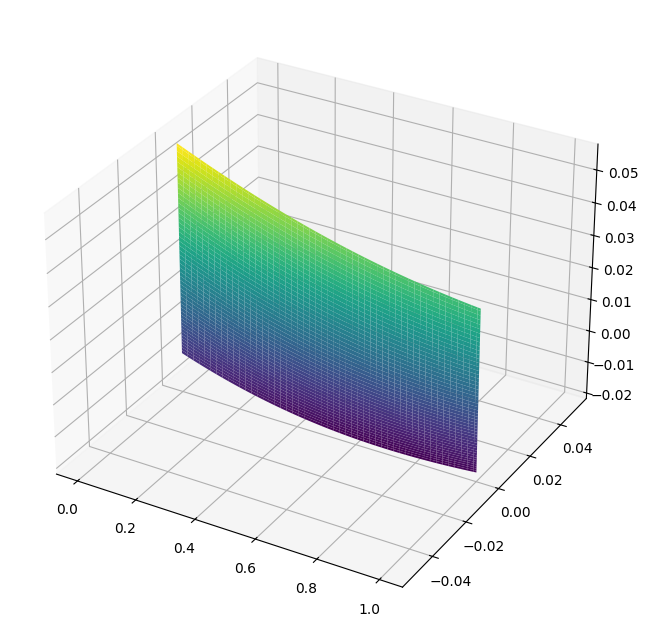

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Определение задачи
def u(x, y, t):
    return torch.cat([x, y, t], dim=1)

# 2. Создание архитектуры PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.output_layer = nn.Linear(layers[-1], 1)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        return self.output_layer(x)

# 3. Определение функции потерь
def compute_loss(model, x, y, t, u_true, alpha=1.0):
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True

    u_pred = model(u(x, y, t))

    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_y = torch.autograd.grad(u_pred, y, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Уравнение теплопроводности
    heat_eq = u_t - alpha * (u_xx + u_yy)

    mse = torch.mean(heat_eq**2)
    boundary_loss = torch.mean((u_pred - u_true)**2)
    total_loss = mse + boundary_loss

    return total_loss

# 4. Создание и обучение модели
def train(model, x_train, y_train, t_train, u_train, epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, x_train, y_train, t_train, u_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Генерация синтетических данных
def generate_data():
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    t = np.linspace(0, 1, 100)
    
    x, y, t = np.meshgrid(x, y, t)
    x = x.flatten()[:, None]
    y = y.flatten()[:, None]
    t = t.flatten()[:, None]
    
    u = np.sin(np.pi * x) * np.sin(np.pi * y) * np.exp(-2 * np.pi**2 * t)
    return x, y, t, u

# Основной код
layers = [3, 20, 20, 20, 1]
model = PINN(layers).to(device)

x_train, y_train, t_train, u_train = generate_data()
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
t_train = torch.tensor(t_train, dtype=torch.float32).to(device)
u_train = torch.tensor(u_train, dtype=torch.float32).to(device)

train(model, x_train, y_train, t_train, u_train)

# 5. Визуализация результатов
def plot_solution(model, x, y, t, t_index):
    model.eval()
    with torch.no_grad():
        # Подготовка данных для визуализации
        x_flat = torch.tensor(x.flatten()[:, None], dtype=torch.float32).to(device)
        y_flat = torch.tensor(y.flatten()[:, None], dtype=torch.float32).to(device)
        t_flat = torch.tensor(t.flatten()[:, None], dtype=torch.float32).to(device)

        u_pred = model(u(x_flat, y_flat, t_flat)).cpu().numpy()
        u_pred = u_pred.reshape((100, 100))
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, u_pred, cmap='viridis')
    plt.show()

x, y, t, _ = generate_data()
x_plot = x[:10000].reshape((100, 100))
y_plot = y[:10000].reshape((100, 100))
t_plot = t[:10000].reshape((100, 100))

# Визуализируем результаты на t=0
plot_solution(model, x_plot, y_plot, t_plot, 0)


Gemini 1.5

In [46]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. Определение задачи
# Допустим, область - квадрат [0, 1] x [0, 1]
# Граничные условия: T(x, 0) = T(x, 1) = T(0, y) = T(1, y) = 0
# Начальное условие: T(x, y, 0) = sin(pi*x)*sin(pi*y)
# Аналитическое решение sin(Pi * x) * sin(Pi * y) * exp(-2 * Pi**2 * t)
# Коэффициент теплопроводности: 1
# Время моделирования: 0.1

# 2. Построение нейронной сети
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.linear_in = nn.Linear(3, 20)
        self.linear1 = nn.Linear(20, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear_out = nn.Linear(20, 1)
        self.activation = nn.Tanh()

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        out = self.activation(self.linear_in(inputs))
        out = self.activation(self.linear1(out))
        out = self.activation(self.linear2(out))
        out = self.linear_out(out)
        return out

# 3. Формулировка функции потерь
def loss_func(model, x, y, t):
    T = model(x, y, t)
    x = x.requires_grad_()
    y = y.requires_grad_()
    t = t.requires_grad_()
    dT_dx = torch.autograd.grad(T.sum(), x, create_graph=True)[0]
    dT_dy = torch.autograd.grad(T.sum(), y, create_graph=True)[0]
    dT_dt = torch.autograd.grad(T.sum(), t, create_graph=True)[0]
    dT_dxx = torch.autograd.grad(dT_dx.sum(), x, create_graph=True)[0]
    dT_dyy = torch.autograd.grad(dT_dy.sum(), y, create_graph=True)[0]

    # Уравнение теплопроводности (MSE loss)
    pde_loss = torch.mean((dT_dt - (dT_dxx + dT_dyy))**2)

    # Граничные условия (MSE loss)
    bc_loss = 1000*torch.mean((T[x == 0] + T[x == 1] + T[y == 0] + T[y == 1])**2)

    # Начальное условие (MSE loss)
    ic_loss = 100*torch.mean((T[t == 0] - torch.sin(np.pi * x[t == 0]) * torch.sin(np.pi * y[t == 0]))**2)

    return pde_loss + bc_loss + ic_loss

# 4. Обучение нейронной сети
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters())

# Генерация точек для обучения
x = torch.linspace(0, 1, 100, requires_grad=True).to(device)
y = torch.linspace(0, 1, 100, requires_grad=True).to(device)
t = torch.linspace(0, 0.1, 10, requires_grad=True).to(device)
X, Y, T = torch.meshgrid(x, y, t)
x = X.flatten().unsqueeze(1)
y = Y.flatten().unsqueeze(1)
t = T.flatten().unsqueeze(1)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_func(model, x, y, t)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 200.0453338623047
Epoch 100, Loss: 24.250192642211914
Epoch 200, Loss: 24.220775604248047
Epoch 300, Loss: 24.186187744140625
Epoch 400, Loss: 24.145401000976562
Epoch 500, Loss: 24.097475051879883
Epoch 600, Loss: 24.03975486755371
Epoch 700, Loss: 23.967693328857422
Epoch 800, Loss: 23.874610900878906
Epoch 900, Loss: 23.752382278442383
Epoch 1000, Loss: 23.596431732177734
Epoch 1100, Loss: 23.420469284057617
Epoch 1200, Loss: 23.270767211914062
Epoch 1300, Loss: 23.187536239624023
Epoch 1400, Loss: 23.14679718017578
Epoch 1500, Loss: 23.109024047851562
Epoch 1600, Loss: 23.055471420288086
Epoch 1700, Loss: 22.963661193847656
Epoch 1800, Loss: 22.744083404541016
Epoch 1900, Loss: 21.84764862060547
Epoch 2000, Loss: 20.86492347717285
Epoch 2100, Loss: 20.60372543334961
Epoch 2200, Loss: 20.216705322265625
Epoch 2300, Loss: 19.594791412353516
Epoch 2400, Loss: 19.021352767944336
Epoch 2500, Loss: 17.679588317871094
Epoch 2600, Loss: 16.540767669677734
Epoch 2700, Loss: 1

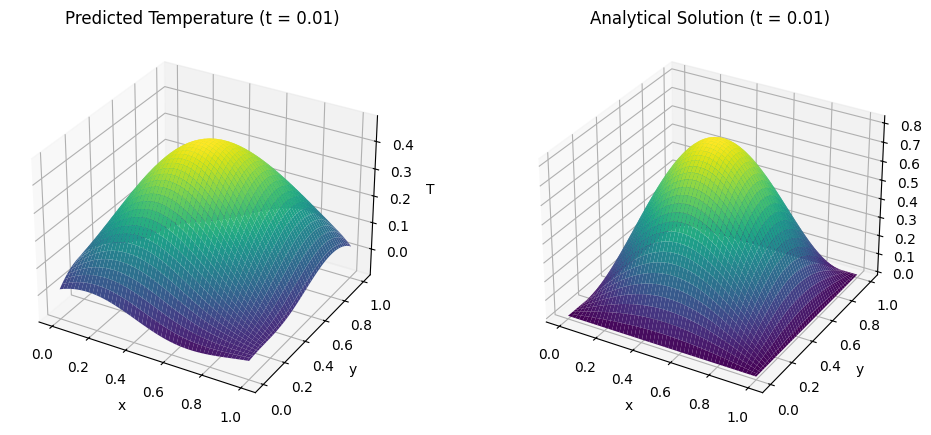

In [48]:
# 5. Визуализация результатов
with torch.no_grad():
    x = torch.linspace(0, 1, 100, requires_grad=True).to(device)
    y = torch.linspace(0, 1, 100, requires_grad=True).to(device)
    X, Y = torch.meshgrid(x, y)
    x = X.flatten().unsqueeze(1)
    y = Y.flatten().unsqueeze(1)

    t_final = 0.01

    # Вычисляем температуру во всей области для последнего момента времени
    T_pred = model(x, y, torch.full_like(x, t_final)).reshape(100, 100)

    # Аналитическое решение для момента времени t_final
    T_analytical = (torch.sin(np.pi * X) * torch.sin(np.pi * Y) * torch.exp(-2 * np.pi**2 * torch.full_like(X, t_final)))

# Визуализация
fig = plt.figure(figsize=(12, 5))

# Предсказанная температура
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X.cpu(), Y.cpu(), T_pred.cpu().numpy(), cmap=cm.viridis)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('T')
ax.set_title('Predicted Temperature (t = {:.2f})'.format(t_final))

# Аналитическое решение
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X.cpu(), Y.cpu(), T_analytical.cpu().numpy(), cmap=cm.viridis)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('T')
ax.set_title('Analytical Solution (t = {:.2f})'.format(t_final))

plt.show()

### PINA using

In [18]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import laplacian, grad
from pina.geometry import CartesianDomain
from pina.solvers import PINN
from pina.trainer import Trainer
from pina.equation import Equation
from pina.equation.equation_factory import FixedValue
from pina import Condition, Plotter

In [21]:
class Heat(TimeDependentProblem, SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x': [0, 1], 'y': [0, 1]})
    temporal_domain = CartesianDomain({'t': [0, 1]})
    
    def heat_equation(input_, output_):
        u_t = grad(output_, input_, components=['u'], d=['t'])
        nabla_u = laplacian(output_, input_, components=['u'], d=['x', 'y'])
        alpha = 0.1
        return u_t - alpha**2 * nabla_u

    def initial_condition(input_, output_):
        u_expected = 5 * torch.sin(torch.pi * input_.extract(['x'])) * torch.sin(torch.pi * input_.extract(['y']))
        return output_.extract(['u']) - u_expected

    conditions = {
        'gamma1': Condition(location=CartesianDomain({'x': 0, 'y': [0, 1], 't': [0, 1]}), equation=FixedValue(input_.extract(['y']))),
        'gamma2': Condition(location=CartesianDomain({'x': 1, 'y': [0, 1], 't': [0, 1]}), equation=FixedValue(input_.extract(['y']))),
        'gamma3': Condition(location=CartesianDomain({'x': [0, 1], 'y': 0, 't': [0, 1]}), equation=FixedValue(input_.extract(['x']))),
        'gamma4': Condition(location=CartesianDomain({'x': [0, 1], 'y': 1, 't': [0, 1]}), equation=FixedValue(input_.extract(['x']))),
        't0': Condition(location=CartesianDomain({'x': [0, 1], 'y': [0, 1], 't': 0}), equation=Equation(initial_condition)),
        'D': Condition(location=CartesianDomain({'x': [0, 1], 'y': [0, 1], 't': [0, 1]}), equation=Equation(heat_equation)),
    }

    def heat_sol(self, pts):
        return 5 * torch.sin(torch.pi*pts.extract(['x'])) * torch.sin(torch.pi*pts.extract(['y'])) * torch.exp(-2*self.alpha**2 * torch.pi**2 * pts.extract(['t'])) + pts.extract(['x']) * pts.extract(['y'])

    truth_solution = heat_sol

NameError: name 'input_' is not defined

In [ ]:
problem = Heat()

In [ ]:
class HardMLP(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, 40),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(40, 40),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(40, output_dim))

    def forward(self, x):
        hard = x.extract(['x']) * x.extract(['y']) * (1 - x.extract(['x'])) * (1 - x.extract(['y']))
        return hard * self.layers(x) + x.extract(['x']) * x.extract(['y'])

In [ ]:
# generate the data
problem.discretise_domain(2000, 'random', locations=['D', 't0', 'gamma1', 'gamma2', 'gamma3', 'gamma4'])

# crete the solver
pinn = PINN(problem, HardMLP(len(problem.input_variables), len(problem.output_variables)))

# create trainer and train
trainer = Trainer(pinn, max_epochs=1000, accelerator='cpu', enable_model_summary=False) # we train on CPU and avoid model summary at beginning of training (optional)
trainer.train()

In [ ]:
plotter = Plotter()

# plotting at fixed time t = 0.0
print('Plotting at t=0')
plotter.plot(pinn, fixed_variables={'t': 0.0})

# plotting at fixed time t = 0.5
print('Plotting at t=0.5')
plotter.plot(pinn, fixed_variables={'t': 0.5})

# plotting at fixed time t = 1.
print('Plotting at t=1')
plotter.plot(pinn, fixed_variables={'t': 1.0})